In [1]:
import numpy
# scipy.special for the sigmoid function expit()
import scipy.special
#import image decoder
import scipy.misc
from skimage import transform, io
import skimage
# library for plotting arrays
import matplotlib.pyplot
import glob
#import time
from time import time
# ensure the plots are inside this notebook, not an external window
% matplotlib inline

# neural network class definition
class neuralNetwork:
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc 
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # learning rate
        self.lr = learningrate

        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)

        pass


    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)

        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)),
                                        numpy.transpose(hidden_outputs))

        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)),
                                        numpy.transpose(inputs))

        pass


    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        return final_outputs


    # backquery the neural network
    # we'll use the same terminology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T

        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01

        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)

        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01

        return inputs


In [2]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learning rate
learning_rate = 0.10

# create instance of neural network
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [3]:
# load the mnist training data CSV file into a list
training_data_file = open("mnist_datasets/mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()
# train the neural network

In [4]:
# epochs is the number of times the training data set is used for training
#after 5 epochs performance = 97.39% LR = 0.1
#after 6 epochs performance = 97.18% LR = 0.1
#after 7 epochs performance = 97.2% LR = 0.1
epochs = 5
t0_train = time()
for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        pass
    pass
t1_train = time()
print("took", (t1_train - t0_train), "secs")

took 777.5901446342468 secs


In [5]:
#load the mnist test data CSV file into a list
test_data_file = open("mnist_datasets/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [6]:
#get the first test record
all_values = test_data_list[0].split(',')
#print the label
print(all_values[0])

7


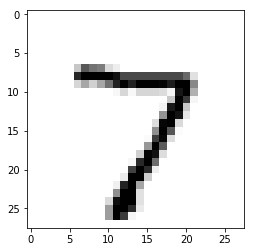

In [7]:
image_array = numpy.asfarray(all_values[1:]).reshape((28, 28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [8]:
n.query((numpy.asfarray(all_values[1:])) / (255.0 * 0.99)) + 0.01

array([[0.01398891],
       [0.02031096],
       [0.01127735],
       [0.01669339],
       [0.01344252],
       [0.02257188],
       [0.02775963],
       [1.0080744 ],
       [0.02068494],
       [0.01365296]])

In [9]:
#load the mnist test data CSV file into a list
test_data_file10 = open("mnist_datasets/mnist_test_10.csv", 'r')
test_data_list10 = test_data_file10.readlines()
test_data_file10.close()

In [10]:
#scorecard for how well the network performs, initially empty
scorecard = []
t0 = time()
#go through all the record in the test data set
for record in test_data_list10:
    #split the record by the ',' commas
    all_values = record.split(',')
    #correct answer is first value
    correct_label = int(all_values[0])
    #scale and shift the inputs
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    #query the network
    outputs = n.query(inputs)
    #the index of the highest value corresponds to the label
    label = numpy.argmax(outputs)
    print(correct_label, "vs.", label)
    #append correct or incorrect to list
    if(label == correct_label):
        #network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        #network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        pass
    pass
t1 = time()
print("took ", (t1 - t0))
print(scorecard)

7 vs. 7
2 vs. 2
1 vs. 1
0 vs. 0
4 vs. 4
1 vs. 1
4 vs. 4
9 vs. 9
5 vs. 5
9 vs. 9
took  0.05664849281311035
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [11]:
#calculate the performance in percentage correct
scorecard_array = numpy.asarray(scorecard)
print("performance = ", (scorecard_array.sum() / scorecard_array.size) * 100, "%")

performance =  100.0 %


In [12]:
#load the mnist test data CSV file into a list
test_data_file_full = open("mnist_datasets/mnist_test.csv", 'r')
test_data_list_full = test_data_file_full.readlines()
test_data_file_full.close()

In [13]:
scorecard_full = []
t0_full = time()
for record in test_data_list_full:
    all_values_full = record.split(',')
    inputs_full = (numpy.asfarray(all_values_full[1:]) / (255.0 * 0.99)) + 0.01
    correct_label_full = int(all_values_full[0])
    outputs_full = n.query(inputs_full)
    label_full = numpy.argmax(outputs_full)
    if(label_full == correct_label_full):
        scorecard_full.append(1)
    else:
        scorecard_full.append(0)
        pass
    pass
t1_full = time()
print("took", (t1_full- t0_full), "seconds")

took 6.732974529266357 seconds


In [14]:
scorecard_full_array = numpy.asarray(scorecard_full)
print("performance = ", (scorecard_full_array.sum() / scorecard_full_array.size) * 100, "%")

performance =  97.14 %


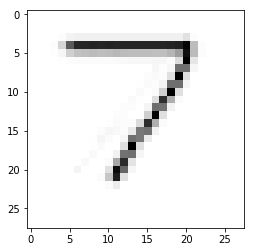

In [15]:
image_array = skimage.io.imread('my_own_images/2828_my_own_7.png', as_grey=True)
# reshape to (1,784)
image_data = 255.0 - image_array.reshape(1, 784)
image_data = (image_data / (255.0 * 0.99)) + 0.01
image_array = numpy.asfarray(image_data).reshape((28, 28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [36]:
our_own_dataset = []

# load the png image data as test data set
for image_file_name in glob.glob('my_own_images/2828_my_own_??.png'):
    
    # use the filename to set the correct label
    label = int(image_file_name[-5:-4])
    
    # load image data from png files into an array
    print ("loading ... ", image_file_name)
    img_array = skimage.io.imread(image_file_name, as_grey=True)
    img_data = 1.0 - img_array.reshape(784)
    img_data = (img_data / 0.99) + 0.01
    print(numpy.min(img_data))
    print(numpy.max(img_data))
    
    # append label and image data  to test data set
    record = numpy.append(label, img_data)
    our_own_dataset.append(record)
    
    pass


loading ...  my_own_images\2828_my_own_00.png
0.01
1.0201010101010102
loading ...  my_own_images\2828_my_own_44.png
0.01
1.0201010101010102
loading ...  my_own_images\2828_my_own_66.png
0.01
1.0201010101010102
loading ...  my_own_images\2828_my_own_77.png
0.01
1.0201010101010102


[[9.34073673e-03]
 [2.32319495e-03]
 [4.17075341e-03]
 [1.79443152e-03]
 [2.33120694e-02]
 [1.27979890e-01]
 [5.32017405e-03]
 [2.05167396e-02]
 [2.87906698e-04]
 [8.38621669e-01]]
network says  9
no match!


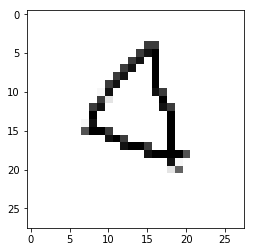

In [37]:
 #test the neural network with our own images
# record to test
item = 1
# plot image
matplotlib.pyplot.imshow(our_own_dataset[item][1:].reshape(28, 28), cmap='Greys', interpolation='None')
# correct answer is first value
correct_label = our_own_dataset[item][0]
# data is remaining values
inputs = our_own_dataset[item][1:]
# query the network
outputs = n.query(inputs)
print (outputs)

# the index of the highest value corresponds to the label
label = numpy.argmax(outputs)
print("network says ", label)
# append correct or incorrect to list
if (label == correct_label):
    print ("match!")
else:
    print ("no match!")
    pass

[0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01]


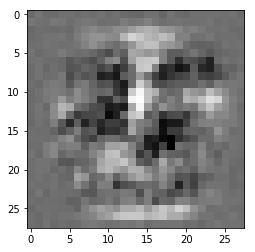

In [35]:
# run the network backwards, given a label, see what image it produces

# label to test
label = 4
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)
# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')